In [1]:
import numpy as np
import matplotlib.pyplot as plt

import hera_sim
from hera_sim import Simulator

from pyuvdata import UVData

from scipy.signal import windows
from numpy.fft import fft, fftshift, ifftshift
from astropy import units

from Delay_Transform import gen_window
from Delay_Transform import fourier_freqs
from Delay_Transform import FFT

Starting with fiducial datasets in uvh5 format, add desired systematics, specifically reflections and coupling for the purposes here. hera_sim furthermore allows for the addition of bandpass gains, rfi, etc.

A single baseline from the HERA Validation sims is included as an example

In [15]:
def Fourier_Transform(freqs,data,freq_taper):

    plot_units = {
        "lst": "hour",
        "time": "day",
        "freq": "MHz",
        "fringe-rate": "mHz",
        "delay": "ns"
    }
    

    scale_factor = 1 # Get FFT data units right.
    
    scale_factor *= np.mean(np.diff(freqs)) # Hz
    delays = fourier_freqs(freqs) * units.s.to(plot_units["delay"])
    data = np.atleast_2d(data)
    data = FFT(data, axis=1, taper=freq_taper)

    
    #Delay Space
    data *= scale_factor
    
    return([delays,data])

In [16]:
UV = UVData()

#Example data set containing foregrounds + EoR signal, for two antennas and a single baseline
UV.read(filename='example_data/zen.2458098.26719.sum.true.1.2.uvh5', bls=[(1,1),(2,2),(1,2)])

Telescope RIMEz calculation is not in known_telescopes.
Fixing auto-correlations to be be real-only, after some imaginary values were detected in data_array.


In [17]:
sim = Simulator(data=UV.copy())
hera_sim.defaults.set("h1c")

In [18]:
#Which baseline/autocorrelation to plot
ant_1, ant_2 = 1, 1

### Add Systematics

In [19]:
#Gains
sim.add(component="gains",seed=1585957365)

#Make a plot of the power spectrum prior to adding systematics, but after gains, for a clearer look at the effects
True_FT = Fourier_Transform(UV.freq_array[0],sim.get_data(ant_1,ant_2,'xx'),'blackman-harris')

In [20]:
#10 coupling peaks with randomisation

sim.add(component="CrossCouplingSpectrum", n_copies=10,
            amp_range=(-4,-6), dly_range=(900,1300), phs_range=(-np.pi,np.pi),
                amp_jitter=0.01, dly_jitter=20, seed=1585964131, symmetrize=False)

You are adding visibilities to a data array *after* multiplicative effects have been introduced.


In [21]:
#Reflection spectrum/20 subreflections

sim.add(component="reflection_spectrum", n_copies=20,
            amp_range=(-3,-4), dly_range=(200,1000), phs_range=(-np.pi,np.pi), 
            amp_jitter=0.01, dly_jitter=30, seed=2440572501)

In [22]:
#2 high-amplitude reflections

sim.add(component="reflections",amp=0.003,amp_jitter=0.01,dly=200,dly_jitter=10,seed=2440572505)
sim.add(component="reflections",amp=0.0008,amp_jitter=0.01,dly=1200,dly_jitter=30,seed=2440572506)

In [10]:
'''Save corrupted data as a single uvh5 file, or multiple np files'''

sim.write('example_data/zen.2458098.26719.sum.corrupt.EXAMPLE.uvh5', save_format="uvh5", fix_autos=True, clobber=True)

'''np.save(file='example_data/zen.2458098.26719.sum.corrupt.1.2.EXAMPLE.npy', arr=sim.get_data(1,2,'xx'))
np.save(file='example_data/zen.2458098.26719.sum.corrupt.1.1.EXAMPLE.npy', arr=sim.get_data(1,1,'xx'))
np.save(file='example_data/zen.2458098.26719.sum.corrupt.2.2.EXAMPLE.npy', arr=sim.get_data(2,2,'xx'))'''

Fixing auto-correlations to be be real-only, after some imaginary values were detected in data_array.


"np.save(file='example_data/zen.2458098.26719.sum.corrupt.1.2.EXAMPLE.npy', arr=sim.get_data(1,2,'xx'))\nnp.save(file='example_data/zen.2458098.26719.sum.corrupt.1.1.EXAMPLE.npy', arr=sim.get_data(1,1,'xx'))\nnp.save(file='example_data/zen.2458098.26719.sum.corrupt.2.2.EXAMPLE.npy', arr=sim.get_data(2,2,'xx'))"

In [31]:
#Plot of the visibility after systematics

Corrupt_FT = Fourier_Transform(UV.freq_array[0],sim.get_data(ant_1,ant_2,'xx'),'blackman-harris')

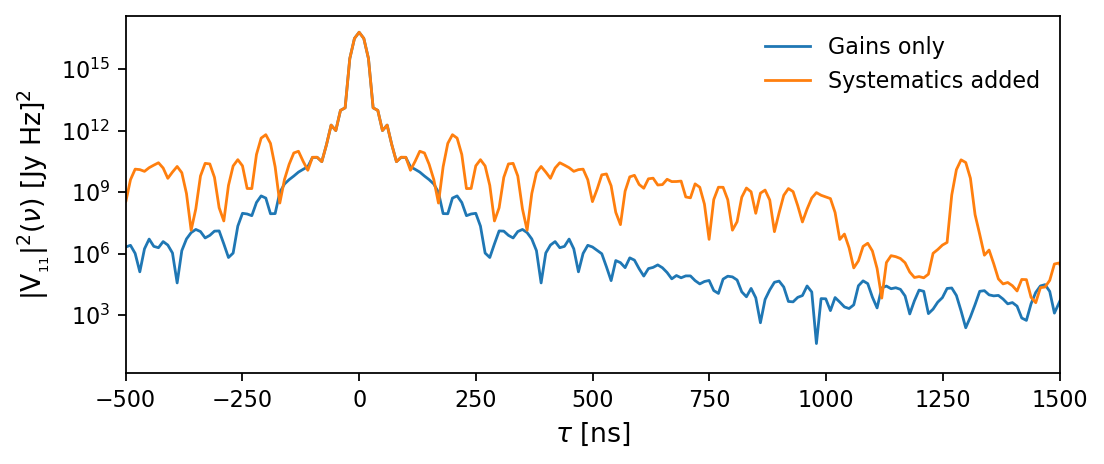

In [32]:
fig, axs = plt.subplots(figsize=(7,3),dpi=160)

plt.plot(True_FT[0], np.abs(True_FT[1][0]*np.conj(True_FT[1][0])), 
         linewidth=1.25, linestyle='-', label='Gains only')

plt.plot(Corrupt_FT[0], np.abs(Corrupt_FT[1][0]*np.conj(Corrupt_FT[1][0])), 
         linewidth=1.25, linestyle='-', label='Systematics added')

plt.legend(frameon=False)
plt.yscale('log')
plt.xlim(-500,1500)
#plt.ylim(1e1,5e17)
plt.xlabel('$\\tau$ [ns]',fontsize=12)
plt.ylabel('|$\\rm{V}_{\\rm_{' +str(ant_1)+str(ant_2)+ '}}$|$^2$($\\nu$) [Jy Hz]$^2$',fontsize=12)
plt.tight_layout()